In [89]:
import numpy as np
import gym
from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import TRPO, QRDQN, MaskablePPO
from stable_baselines3.dqn.policies import MlpPolicy as DQNMlpPolicy
import matplotlib.pyplot as plt

In [134]:
# Improved Environment
class ImprovedCraneSafetyEnv(gym.Env):
    def __init__(self):
        super(ImprovedCraneSafetyEnv, self).__init__()
        # State: [Supervision level, TCU compliance, RPR compliance]
        self.state = np.array([1.0, 0.5, 0.5], dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)  # [Low, Medium, High supervision]
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.environment = {
            "wind_speed": np.random.uniform(0.2, 0.4),
            "visibility": np.random.uniform(0.6, 0.9),
            "load_variability": np.random.uniform(0.1, 0.5),
        }
        self.time_step = 0
        self.accident_counter = 0  # Count accidents during training

    #def reset_environment(self):
        #""" Randomized environment for robustness. """
     #   self.environment = {
      #      "wind_speed": np.random.uniform(0.2, 0.4),
       #     "visibility": np.random.uniform(0.6, 0.9),
        #    "load_variability": np.random.uniform(0.1, 0.5)
        #}

    def step(self, action):
        # Supervision level determined by action
        supervision = action + 1

        # Environmental factors
        wind = self.environment["wind_speed"]
        visibility = self.environment["visibility"]
        load_var = self.environment["load_variability"]

        # Improved Compliance Models
        compliance_t = 1 / (1 + np.exp(-0.7 * (supervision - 2 + visibility - 0.5)))
        compliance_r = 1 / (1 + np.exp(-0.6 * (supervision - 2 + wind - 0.4)))

        # Accident probability adjusted for smoother impact
        accident_prob = (1 - (compliance_t + compliance_r) / 2) + 0.05 * load_var
        #max(0.1,

        # Accident threshold
        if accident_prob > 0.3:  # Customize this threshold as needed
            self.accident_counter += 1
        
        # Costs
        cost_supervision = supervision * 10
        cost_accident = accident_prob * 80  # Lower accident penalty for stability

        # Reward shaping
        reward = -cost_supervision - cost_accident
        reward += 200 * compliance_t + 200 * compliance_r + 100 * (1 - accident_prob)

        # Update environment factors with smoother randomness
        for key in self.environment:
            self.environment[key] = np.clip(self.environment[key] + np.random.uniform(-0.01, 0.01), 0, 1)

        # Update state
        self.state = np.array([supervision, compliance_t, compliance_r], dtype=np.float32)
        self.time_step += 1

        # Episode end
        done = self.time_step >= 50
        return self.state, reward, done, {}

    def reset(self):
        self.state = np.array([1.0, 0.5, 0.5], dtype=np.float32)
        self.environment = {
            "wind_speed": np.random.uniform(0.2, 0.4),
            "visibility": np.random.uniform(0.6, 0.9),
            "load_variability": np.random.uniform(0.1, 0.5),
        }
        self.time_step = 0
        self.accident_counter = 0  # Reset accident counter
        return self.state

In [125]:
# Initialize environment
env = ImprovedCraneSafetyEnv()
accident_counts = {}

In [126]:
# Train PPO Agent
print("\nTraining PPO Agent...")
PPO_model = model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, n_steps=1024, batch_size=64, gamma=0.99, clip_range=0.2)
PPO_model.learn(total_timesteps=120000)
accident_counts[PPO_model]=env.accident_counter
print(f"PPO - Total Accidents During Training: {env.accident_counter}")


Training PPO Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\zaida\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 9.74e+03 |
| time/              |          |
|    fps             | 688      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 9.84e+03     |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0015109454 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -8.34e-07    |
|    learning_r

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.05e+04      |
| time/                   |               |
|    fps                  | 432           |
|    iterations           | 11            |
|    time_elapsed         | 26            |
|    total_timesteps      | 11264         |
| train/                  |               |
|    approx_kl            | 0.00018515723 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.06         |
|    explained_variance   | -4.65e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.67e+06      |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.000385     |
|    value_loss           | 6.75e+06      |
-------------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 1.15e+04     |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 20           |
|    time_elapsed         | 48           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0005668143 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.918       |
|    explained_variance   | 7.15e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.86e+06     |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00172     |
|    value_loss           | 7.98e+06     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.22e+04      |
| time/                   |               |
|    fps                  | 422           |
|    iterations           | 29            |
|    time_elapsed         | 70            |
|    total_timesteps      | 29696         |
| train/                  |               |
|    approx_kl            | 0.00039346085 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.762        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.3e+06       |
|    n_updates            | 280           |
|    policy_gradient_loss | -0.000946     |
|    value_loss           | 9.15e+06      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.27e+04      |
| time/                   |               |
|    fps                  | 421           |
|    iterations           | 38            |
|    time_elapsed         | 92            |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 0.00010868313 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.581        |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.4e+06       |
|    n_updates            | 370           |
|    policy_gradient_loss | -0.00033      |
|    value_loss           | 9.63e+06      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 1.3e+04      |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 47           |
|    time_elapsed         | 114          |
|    total_timesteps      | 48128        |
| train/                  |              |
|    approx_kl            | 8.932676e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.451       |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.73e+06     |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.000367    |
|    value_loss           | 9.96e+06     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.32e+04      |
| time/                   |               |
|    fps                  | 418           |
|    iterations           | 57            |
|    time_elapsed         | 139           |
|    total_timesteps      | 58368         |
| train/                  |               |
|    approx_kl            | 5.3783413e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.383        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 5.21e+06      |
|    n_updates            | 560           |
|    policy_gradient_loss | -0.000215     |
|    value_loss           | 1.02e+07      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.33e+04      |
| time/                   |               |
|    fps                  | 418           |
|    iterations           | 66            |
|    time_elapsed         | 161           |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 2.8582232e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.341        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 5e+06         |
|    n_updates            | 650           |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 1.02e+07      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 1.33e+04     |
| time/                   |              |
|    fps                  | 418          |
|    iterations           | 75           |
|    time_elapsed         | 183          |
|    total_timesteps      | 76800        |
| train/                  |              |
|    approx_kl            | 7.709366e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 5.61e+06     |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.000447    |
|    value_loss           | 1.06e+07     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.34e+04      |
| time/                   |               |
|    fps                  | 417           |
|    iterations           | 84            |
|    time_elapsed         | 205           |
|    total_timesteps      | 86016         |
| train/                  |               |
|    approx_kl            | 1.8584658e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.255        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.71e+06      |
|    n_updates            | 830           |
|    policy_gradient_loss | -0.000188     |
|    value_loss           | 1.06e+07      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.35e+04      |
| time/                   |               |
|    fps                  | 417           |
|    iterations           | 93            |
|    time_elapsed         | 228           |
|    total_timesteps      | 95232         |
| train/                  |               |
|    approx_kl            | 6.3730404e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.204        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.95e+06      |
|    n_updates            | 920           |
|    policy_gradient_loss | -5.56e-05     |
|    value_loss           | 1.06e+07      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.35e+04      |
| time/                   |               |
|    fps                  | 416           |
|    iterations           | 102           |
|    time_elapsed         | 251           |
|    total_timesteps      | 104448        |
| train/                  |               |
|    approx_kl            | 6.3865446e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.181        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 5.27e+06      |
|    n_updates            | 1010          |
|    policy_gradient_loss | -2.04e-05     |
|    value_loss           | 1.07e+07      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 50            |
|    ep_rew_mean          | 1.36e+04      |
| time/                   |               |
|    fps                  | 415           |
|    iterations           | 111           |
|    time_elapsed         | 273           |
|    total_timesteps      | 113664        |
| train/                  |               |
|    approx_kl            | 4.4167973e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.173        |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.19e+06      |
|    n_updates            | 1100          |
|    policy_gradient_loss | -1.26e-05     |
|    value_loss           | 1.05e+07      |
-------------------------------------------
------------------------------------------
| rollout/                |      

In [127]:
# Train A2C Agent
print("\nTraining A2C Agent...")
A2C_model = A2C("MlpPolicy", env, verbose=1, learning_rate=0.0003, gamma=0.99)
A2C_model.learn(total_timesteps=120000)
accident_counts[A2C_model]=env.accident_counter
print(f"A2C - Total Accidents During Training: {env.accident_counter}")


Training A2C Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.04e+04 |
| time/                 |          |
|    fps                | 489      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.05    |
|    explained_variance | 0.000342 |
|    learning_rate      | 0.0003   |
|    n_updates          | 99       |
|    policy_loss        | 621      |
|    value_loss         | 5.49e+05 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.04e+04 |
| time/                 |          |
|    fps                | 505      |
|    iterations         | 200   

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.31e+04  |
| time/                 |           |
|    fps                | 560       |
|    iterations         | 1400      |
|    time_elapsed       | 12        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -0.145    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0003    |
|    n_updates          | 1399      |
|    policy_loss        | 25        |
|    value_loss         | 8e+05     |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.34e+04  |
| time/                 |           |
|    fps                | 557       |
|    iterations         | 1500      |
|    time_elapsed       | 13        |
|    total_timesteps    | 7500      |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 546       |
|    iterations         | 2700      |
|    time_elapsed       | 24        |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -0.0202   |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0003    |
|    n_updates          | 2699      |
|    policy_loss        | 2.26      |
|    value_loss         | 8e+05     |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.37e+04 |
| time/                 |          |
|    fps                | 545      |
|    iterations         | 2800     |
|    time_elapsed       | 25       |
|    total_timesteps    | 14000    |
| train/             

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.38e+04 |
| time/                 |          |
|    fps                | 540      |
|    iterations         | 4000     |
|    time_elapsed       | 36       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.0072  |
|    explained_variance | 0        |
|    learning_rate      | 0.0003   |
|    n_updates          | 3999     |
|    policy_loss        | 0.728    |
|    value_loss         | 8.14e+05 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.38e+04 |
| time/                 |          |
|    fps                | 541      |
|    iterations         | 4100     |
|    time_elapsed       | 37       |
|    total_timesteps    | 20500    |
| train/                |          |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 544       |
|    iterations         | 5300      |
|    time_elapsed       | 48        |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -0.00166  |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0003    |
|    n_updates          | 5299      |
|    policy_loss        | 0.136     |
|    value_loss         | 7.82e+05  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.37e+04 |
| time/                 |          |
|    fps                | 545      |
|    iterations         | 5400     |
|    time_elapsed       | 49       |
|    total_timesteps    | 27000    |
| train/             

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 542       |
|    iterations         | 6600      |
|    time_elapsed       | 60        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -8.88e-05 |
|    explained_variance | 2.38e-07  |
|    learning_rate      | 0.0003    |
|    n_updates          | 6599      |
|    policy_loss        | 0.00537   |
|    value_loss         | 7.88e+05  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 50       |
|    ep_rew_mean        | 1.37e+04 |
| time/                 |          |
|    fps                | 541      |
|    iterations         | 6700     |
|    time_elapsed       | 61       |
|    total_timesteps    | 33500    |
| train/             

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 543       |
|    iterations         | 7900      |
|    time_elapsed       | 72        |
|    total_timesteps    | 39500     |
| train/                |           |
|    entropy_loss       | -3.24e-05 |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0003    |
|    n_updates          | 7899      |
|    policy_loss        | 0.0019    |
|    value_loss         | 7.75e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 543       |
|    iterations         | 8000      |
|    time_elapsed       | 73        |
|    total_timesteps    | 40000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 543       |
|    iterations         | 9200      |
|    time_elapsed       | 84        |
|    total_timesteps    | 46000     |
| train/                |           |
|    entropy_loss       | -2.03e-05 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 9199      |
|    policy_loss        | 0.00115   |
|    value_loss         | 7.84e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 543       |
|    iterations         | 9300      |
|    time_elapsed       | 85        |
|    total_timesteps    | 46500     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 541       |
|    iterations         | 10500     |
|    time_elapsed       | 96        |
|    total_timesteps    | 52500     |
| train/                |           |
|    entropy_loss       | -1.49e-05 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 10499     |
|    policy_loss        | 0.000775  |
|    value_loss         | 8.03e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 541       |
|    iterations         | 10600     |
|    time_elapsed       | 97        |
|    total_timesteps    | 53000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 541       |
|    iterations         | 11800     |
|    time_elapsed       | 108       |
|    total_timesteps    | 59000     |
| train/                |           |
|    entropy_loss       | -1.19e-05 |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0003    |
|    n_updates          | 11799     |
|    policy_loss        | 0.000773  |
|    value_loss         | 8e+05     |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 541       |
|    iterations         | 11900     |
|    time_elapsed       | 109       |
|    total_timesteps    | 59500     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 13100     |
|    time_elapsed       | 121       |
|    total_timesteps    | 65500     |
| train/                |           |
|    entropy_loss       | -9.72e-06 |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0003    |
|    n_updates          | 13099     |
|    policy_loss        | 0.000775  |
|    value_loss         | 8.03e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 13200     |
|    time_elapsed       | 122       |
|    total_timesteps    | 66000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 14400     |
|    time_elapsed       | 133       |
|    total_timesteps    | 72000     |
| train/                |           |
|    entropy_loss       | -7.66e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 14399     |
|    policy_loss        | -0        |
|    value_loss         | 8.26e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 14500     |
|    time_elapsed       | 134       |
|    total_timesteps    | 72500     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 15700     |
|    time_elapsed       | 145       |
|    total_timesteps    | 78500     |
| train/                |           |
|    entropy_loss       | -7.19e-06 |
|    explained_variance | 2.38e-07  |
|    learning_rate      | 0.0003    |
|    n_updates          | 15699     |
|    policy_loss        | -0        |
|    value_loss         | 7.9e+05   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 15800     |
|    time_elapsed       | 146       |
|    total_timesteps    | 79000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 539       |
|    iterations         | 17000     |
|    time_elapsed       | 157       |
|    total_timesteps    | 85000     |
| train/                |           |
|    entropy_loss       | -6.76e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 16999     |
|    policy_loss        | -0        |
|    value_loss         | 8.16e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 539       |
|    iterations         | 17100     |
|    time_elapsed       | 158       |
|    total_timesteps    | 85500     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 18300     |
|    time_elapsed       | 169       |
|    total_timesteps    | 91500     |
| train/                |           |
|    entropy_loss       | -6.39e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 18299     |
|    policy_loss        | -0        |
|    value_loss         | 7.89e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 540       |
|    iterations         | 18400     |
|    time_elapsed       | 170       |
|    total_timesteps    | 92000     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 541       |
|    iterations         | 19600     |
|    time_elapsed       | 181       |
|    total_timesteps    | 98000     |
| train/                |           |
|    entropy_loss       | -6.06e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 19599     |
|    policy_loss        | -0        |
|    value_loss         | 8.06e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 541       |
|    iterations         | 19700     |
|    time_elapsed       | 181       |
|    total_timesteps    | 98500     |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 542       |
|    iterations         | 20900     |
|    time_elapsed       | 192       |
|    total_timesteps    | 104500    |
| train/                |           |
|    entropy_loss       | -5.78e-06 |
|    explained_variance | 0         |
|    learning_rate      | 0.0003    |
|    n_updates          | 20899     |
|    policy_loss        | -0        |
|    value_loss         | 7.69e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 542       |
|    iterations         | 21000     |
|    time_elapsed       | 193       |
|    total_timesteps    | 105000    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.37e+04  |
| time/                 |           |
|    fps                | 542       |
|    iterations         | 22200     |
|    time_elapsed       | 204       |
|    total_timesteps    | 111000    |
| train/                |           |
|    entropy_loss       | -5.51e-06 |
|    explained_variance | 2.38e-07  |
|    learning_rate      | 0.0003    |
|    n_updates          | 22199     |
|    policy_loss        | -0        |
|    value_loss         | 8.03e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 542       |
|    iterations         | 22300     |
|    time_elapsed       | 205       |
|    total_timesteps    | 111500    |
| train/    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 543       |
|    iterations         | 23500     |
|    time_elapsed       | 216       |
|    total_timesteps    | 117500    |
| train/                |           |
|    entropy_loss       | -5.27e-06 |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0003    |
|    n_updates          | 23499     |
|    policy_loss        | -0        |
|    value_loss         | 7.99e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 50        |
|    ep_rew_mean        | 1.38e+04  |
| time/                 |           |
|    fps                | 543       |
|    iterations         | 23600     |
|    time_elapsed       | 217       |
|    total_timesteps    | 118000    |
| train/    

In [128]:
# Train TRPO Agent
print("\nTraining TRPO Agent...")
TRPO_model = TRPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, batch_size=64, gamma=0.99)
TRPO_model.learn(total_timesteps=120000)
accident_counts[TRPO_model]=env.accident_counter
print(f"TRPO - Total Accidents During Training: {env.accident_counter}")


Training TRPO Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 9.67e+03 |
| time/              |          |
|    fps             | 968      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 50       |
|    ep_rew_mean            | 9.91e+03 |
| time/                     |          |
|    fps                    | 841      |
|    iterations             | 2        |
|    time_elapsed           | 4        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 8.23e-06 |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00879  |
|    lear

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 50        |
|    ep_rew_mean            | 1.34e+04  |
| time/                     |           |
|    fps                    | 832       |
|    iterations             | 13        |
|    time_elapsed           | 31        |
|    total_timesteps        | 26624     |
| train/                    |           |
|    explained_variance     | -5.96e-07 |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.00564   |
|    learning_rate          | 0.0003    |
|    n_updates              | 12        |
|    policy_objective       | 0.00295   |
|    value_loss             | 1.09e+07  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 50        |
|    ep_rew_mean            | 1.35e+04  |
| time/                     |           |
|    fps                    | 828 

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 50        |
|    ep_rew_mean            | 1.36e+04  |
| time/                     |           |
|    fps                    | 827       |
|    iterations             | 24        |
|    time_elapsed           | 59        |
|    total_timesteps        | 49152     |
| train/                    |           |
|    explained_variance     | -1.19e-07 |
|    is_line_search_success | 1         |
|    kl_divergence_loss     | 0.0053    |
|    learning_rate          | 0.0003    |
|    n_updates              | 23        |
|    policy_objective       | 0.0019    |
|    value_loss             | 1.12e+07  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 50        |
|    ep_rew_mean            | 1.37e+04  |
| time/                     |           |
|    fps                    | 828 

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 50       |
|    ep_rew_mean            | 1.38e+04 |
| time/                     |          |
|    fps                    | 827      |
|    iterations             | 35       |
|    time_elapsed           | 86       |
|    total_timesteps        | 71680    |
| train/                    |          |
|    explained_variance     | 0        |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00238  |
|    learning_rate          | 0.0003   |
|    n_updates              | 34       |
|    policy_objective       | 0.000811 |
|    value_loss             | 1.12e+07 |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 50       |
|    ep_rew_mean            | 1.37e+04 |
| time/                     |          |
|    fps                    | 826      |
|    iterations 

----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 50       |
|    ep_rew_mean            | 1.38e+04 |
| time/                     |          |
|    fps                    | 825      |
|    iterations             | 46       |
|    time_elapsed           | 114      |
|    total_timesteps        | 94208    |
| train/                    |          |
|    explained_variance     | 0        |
|    is_line_search_success | 0        |
|    kl_divergence_loss     | 0        |
|    learning_rate          | 0.0003   |
|    n_updates              | 45       |
|    policy_objective       | 7.64e-08 |
|    value_loss             | 1.11e+07 |
----------------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 50       |
|    ep_rew_mean            | 1.38e+04 |
| time/                     |          |
|    fps                    | 824      |
|    iterations 

-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 50        |
|    ep_rew_mean            | 1.38e+04  |
| time/                     |           |
|    fps                    | 826       |
|    iterations             | 57        |
|    time_elapsed           | 141       |
|    total_timesteps        | 116736    |
| train/                    |           |
|    explained_variance     | 5.96e-08  |
|    is_line_search_success | 0         |
|    kl_divergence_loss     | 0         |
|    learning_rate          | 0.0003    |
|    n_updates              | 56        |
|    policy_objective       | -2.37e-08 |
|    value_loss             | 1.09e+07  |
-----------------------------------------
-----------------------------------------
| rollout/                  |           |
|    ep_len_mean            | 50        |
|    ep_rew_mean            | 1.38e+04  |
| time/                     |           |
|    fps                    | 826 

In [129]:
# Train DQN Agent
print("\nTraining DQN Agent...")
DQN_model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.0003, batch_size=64, gamma=0.99)
DQN_model.learn(total_timesteps=120000)
accident_counts[DQN_model]=env.accident_counter
print(f"DQN - Total Accidents During Training: {env.accident_counter}")


Training DQN Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.92e+03 |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1622     |
|    time_elapsed     | 0        |
|    total_timesteps  | 200      |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 193      |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.86e+03 |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1472     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
| train/

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.03e+04 |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 1123     |
|    time_elapsed     | 3        |
|    total_timesteps  | 3400     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 40.9     |
|    n_updates        | 824      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.03e+04 |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 1118     |
|    time_elapsed     | 3        |
|    total_timesteps  | 3600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 36.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.1e+04  |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 1076     |
|    time_elapsed     | 6        |
|    total_timesteps  | 6600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 29.4     |
|    n_updates        | 1624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.1e+04  |
|    exploration_rate | 0.462    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 1072     |
|    time_elapsed     | 6        |
|    total_timesteps  | 6800     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 25.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.2e+04  |
|    exploration_rate | 0.224    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 1043     |
|    time_elapsed     | 9        |
|    total_timesteps  | 9800     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.13     |
|    n_updates        | 2424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.21e+04 |
|    exploration_rate | 0.208    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1034     |
|    time_elapsed     | 9        |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.4      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.3e+04  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 977      |
|    time_elapsed     | 13       |
|    total_timesteps  | 13000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 13.7     |
|    n_updates        | 3224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.3e+04  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 976      |
|    time_elapsed     | 13       |
|    total_timesteps  | 13200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 12.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 945      |
|    time_elapsed     | 17       |
|    total_timesteps  | 16200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 12.1     |
|    n_updates        | 4024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 944      |
|    time_elapsed     | 17       |
|    total_timesteps  | 16400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 9.06     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 935      |
|    time_elapsed     | 20       |
|    total_timesteps  | 19400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 10.4     |
|    n_updates        | 4824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 935      |
|    time_elapsed     | 20       |
|    total_timesteps  | 19600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 6.82     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 924      |
|    time_elapsed     | 24       |
|    total_timesteps  | 22600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 33.4     |
|    n_updates        | 5624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 924      |
|    time_elapsed     | 24       |
|    total_timesteps  | 22800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 5.67     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 910      |
|    time_elapsed     | 28       |
|    total_timesteps  | 25800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 6.35     |
|    n_updates        | 6424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 909      |
|    time_elapsed     | 28       |
|    total_timesteps  | 26000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 12.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 902      |
|    time_elapsed     | 32       |
|    total_timesteps  | 29000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 19.2     |
|    n_updates        | 7224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 901      |
|    time_elapsed     | 32       |
|    total_timesteps  | 29200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 18.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 897      |
|    time_elapsed     | 35       |
|    total_timesteps  | 32200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.97     |
|    n_updates        | 8024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 897      |
|    time_elapsed     | 36       |
|    total_timesteps  | 32400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 20.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 894      |
|    time_elapsed     | 39       |
|    total_timesteps  | 35400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 16.8     |
|    n_updates        | 8824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 894      |
|    time_elapsed     | 39       |
|    total_timesteps  | 35600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 41.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 879      |
|    time_elapsed     | 43       |
|    total_timesteps  | 38600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 29.1     |
|    n_updates        | 9624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 878      |
|    time_elapsed     | 44       |
|    total_timesteps  | 38800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 27.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 875      |
|    time_elapsed     | 47       |
|    total_timesteps  | 41800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 56.3     |
|    n_updates        | 10424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 875      |
|    time_elapsed     | 47       |
|    total_timesteps  | 42000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.36     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 873      |
|    time_elapsed     | 51       |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 20.9     |
|    n_updates        | 11224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 873      |
|    time_elapsed     | 51       |
|    total_timesteps  | 45200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 38.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 964      |
|    fps              | 873      |
|    time_elapsed     | 55       |
|    total_timesteps  | 48200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.59     |
|    n_updates        | 12024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 873      |
|    time_elapsed     | 55       |
|    total_timesteps  | 48400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 19       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 873      |
|    time_elapsed     | 58       |
|    total_timesteps  | 51400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 32.7     |
|    n_updates        | 12824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 873      |
|    time_elapsed     | 59       |
|    total_timesteps  | 51600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 31       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 871      |
|    time_elapsed     | 62       |
|    total_timesteps  | 54600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 49.2     |
|    n_updates        | 13624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 870      |
|    time_elapsed     | 62       |
|    total_timesteps  | 54800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 50.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 870      |
|    time_elapsed     | 66       |
|    total_timesteps  | 57800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 45.9     |
|    n_updates        | 14424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 870      |
|    time_elapsed     | 66       |
|    total_timesteps  | 58000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 27.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 872      |
|    time_elapsed     | 69       |
|    total_timesteps  | 61000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 12.1     |
|    n_updates        | 15224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 871      |
|    time_elapsed     | 70       |
|    total_timesteps  | 61200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 57.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 871      |
|    time_elapsed     | 73       |
|    total_timesteps  | 64200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 84.7     |
|    n_updates        | 16024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 871      |
|    time_elapsed     | 73       |
|    total_timesteps  | 64400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 86.7     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 867      |
|    time_elapsed     | 77       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 35.8     |
|    n_updates        | 16824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 867      |
|    time_elapsed     | 77       |
|    total_timesteps  | 67600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 5.7      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 863      |
|    time_elapsed     | 81       |
|    total_timesteps  | 70600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 70.4     |
|    n_updates        | 17624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 863      |
|    time_elapsed     | 82       |
|    total_timesteps  | 70800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 11.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 861      |
|    time_elapsed     | 85       |
|    total_timesteps  | 73800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 31.2     |
|    n_updates        | 18424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 861      |
|    time_elapsed     | 85       |
|    total_timesteps  | 74000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 5.28     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 861      |
|    time_elapsed     | 89       |
|    total_timesteps  | 77000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 15.7     |
|    n_updates        | 19224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 861      |
|    time_elapsed     | 89       |
|    total_timesteps  | 77200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 5.76     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 859      |
|    time_elapsed     | 93       |
|    total_timesteps  | 80200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 188      |
|    n_updates        | 20024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 858      |
|    time_elapsed     | 93       |
|    total_timesteps  | 80400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 22.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 857      |
|    time_elapsed     | 97       |
|    total_timesteps  | 83400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 69.1     |
|    n_updates        | 20824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 857      |
|    time_elapsed     | 97       |
|    total_timesteps  | 83600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 14       |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 856      |
|    time_elapsed     | 101      |
|    total_timesteps  | 86600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 6.55     |
|    n_updates        | 21624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 856      |
|    time_elapsed     | 101      |
|    total_timesteps  | 86800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 82.6     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 856      |
|    time_elapsed     | 104      |
|    total_timesteps  | 89800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 35.8     |
|    n_updates        | 22424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 856      |
|    time_elapsed     | 105      |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 34.8     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 856      |
|    time_elapsed     | 108      |
|    total_timesteps  | 93000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 11.4     |
|    n_updates        | 23224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 856      |
|    time_elapsed     | 108      |
|    total_timesteps  | 93200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 43.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 856      |
|    time_elapsed     | 112      |
|    total_timesteps  | 96200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.67     |
|    n_updates        | 24024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 856      |
|    time_elapsed     | 112      |
|    total_timesteps  | 96400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 150      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 856      |
|    time_elapsed     | 116      |
|    total_timesteps  | 99400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 38.7     |
|    n_updates        | 24824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 855      |
|    time_elapsed     | 116      |
|    total_timesteps  | 99600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 11.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 854      |
|    time_elapsed     | 120      |
|    total_timesteps  | 102600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 14.4     |
|    n_updates        | 25624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 854      |
|    time_elapsed     | 120      |
|    total_timesteps  | 102800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 92.1     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 853      |
|    time_elapsed     | 123      |
|    total_timesteps  | 105800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.41     |
|    n_updates        | 26424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 853      |
|    time_elapsed     | 124      |
|    total_timesteps  | 106000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 88.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 853      |
|    time_elapsed     | 127      |
|    total_timesteps  | 109000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 52.7     |
|    n_updates        | 27224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 853      |
|    time_elapsed     | 127      |
|    total_timesteps  | 109200   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 46.9     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 853      |
|    time_elapsed     | 131      |
|    total_timesteps  | 112200   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 48.1     |
|    n_updates        | 28024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 853      |
|    time_elapsed     | 131      |
|    total_timesteps  | 112400   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 57.4     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 853      |
|    time_elapsed     | 135      |
|    total_timesteps  | 115400   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 18.3     |
|    n_updates        | 28824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 853      |
|    time_elapsed     | 135      |
|    total_timesteps  | 115600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 57.5     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 852      |
|    time_elapsed     | 139      |
|    total_timesteps  | 118600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 97.1     |
|    n_updates        | 29624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 852      |
|    time_elapsed     | 139      |
|    total_timesteps  | 118800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 57.4     |
|    n_updates      

In [130]:
# Train Double DQN Agent
print("\nTraining Double DQN Agent...")
DoubleDQN_model = DQN(DQNMlpPolicy, env, verbose=1, learning_rate=0.0003, batch_size=64, gamma=0.99, target_update_interval=500)
DoubleDQN_model.learn(total_timesteps=120000)
accident_counts[DoubleDQN_model]=env.accident_counter
print(f"Double DQN - Total Accidents During Training: {env.accident_counter}")


Training Double DQN Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.51e+03 |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1916     |
|    time_elapsed     | 0        |
|    total_timesteps  | 200      |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 193      |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.59e+03 |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1404     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
|

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.27e+03 |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 1114     |
|    time_elapsed     | 3        |
|    total_timesteps  | 3400     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 150      |
|    n_updates        | 824      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.4e+03  |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 1093     |
|    time_elapsed     | 3        |
|    total_timesteps  | 3600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 177      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.06e+04 |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 1041     |
|    time_elapsed     | 6        |
|    total_timesteps  | 6600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 432      |
|    n_updates        | 1624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.07e+04 |
|    exploration_rate | 0.462    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 1040     |
|    time_elapsed     | 6        |
|    total_timesteps  | 6800     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 246      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.22e+04 |
|    exploration_rate | 0.224    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 989      |
|    time_elapsed     | 9        |
|    total_timesteps  | 9800     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 561      |
|    n_updates        | 2424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.22e+04 |
|    exploration_rate | 0.208    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 985      |
|    time_elapsed     | 10       |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 396      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.31e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 948      |
|    time_elapsed     | 13       |
|    total_timesteps  | 13000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 261      |
|    n_updates        | 3224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.32e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 946      |
|    time_elapsed     | 13       |
|    total_timesteps  | 13200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 494      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 911      |
|    time_elapsed     | 17       |
|    total_timesteps  | 16200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 656      |
|    n_updates        | 4024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 909      |
|    time_elapsed     | 18       |
|    total_timesteps  | 16400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 530      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 896      |
|    time_elapsed     | 21       |
|    total_timesteps  | 19400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.08e+03 |
|    n_updates        | 4824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 895      |
|    time_elapsed     | 21       |
|    total_timesteps  | 19600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 726      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 883      |
|    time_elapsed     | 25       |
|    total_timesteps  | 22600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 511      |
|    n_updates        | 5624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 882      |
|    time_elapsed     | 25       |
|    total_timesteps  | 22800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 711      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 881      |
|    time_elapsed     | 29       |
|    total_timesteps  | 25800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 653      |
|    n_updates        | 6424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 881      |
|    time_elapsed     | 29       |
|    total_timesteps  | 26000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 927      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 874      |
|    time_elapsed     | 33       |
|    total_timesteps  | 29000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 659      |
|    n_updates        | 7224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 874      |
|    time_elapsed     | 33       |
|    total_timesteps  | 29200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 878      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 872      |
|    time_elapsed     | 36       |
|    total_timesteps  | 32200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 591      |
|    n_updates        | 8024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 872      |
|    time_elapsed     | 37       |
|    total_timesteps  | 32400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.03e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 869      |
|    time_elapsed     | 40       |
|    total_timesteps  | 35400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 899      |
|    n_updates        | 8824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 869      |
|    time_elapsed     | 40       |
|    total_timesteps  | 35600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 786      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 869      |
|    time_elapsed     | 44       |
|    total_timesteps  | 38600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.04e+03 |
|    n_updates        | 9624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 870      |
|    time_elapsed     | 44       |
|    total_timesteps  | 38800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 858      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 865      |
|    time_elapsed     | 48       |
|    total_timesteps  | 41800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 333      |
|    n_updates        | 10424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 865      |
|    time_elapsed     | 48       |
|    total_timesteps  | 42000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 699      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 862      |
|    time_elapsed     | 52       |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 752      |
|    n_updates        | 11224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 862      |
|    time_elapsed     | 52       |
|    total_timesteps  | 45200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 875      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 964      |
|    fps              | 861      |
|    time_elapsed     | 55       |
|    total_timesteps  | 48200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.24e+03 |
|    n_updates        | 12024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 860      |
|    time_elapsed     | 56       |
|    total_timesteps  | 48400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.35e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 854      |
|    time_elapsed     | 60       |
|    total_timesteps  | 51400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 614      |
|    n_updates        | 12824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 853      |
|    time_elapsed     | 60       |
|    total_timesteps  | 51600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.35e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 846      |
|    time_elapsed     | 64       |
|    total_timesteps  | 54600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.83e+03 |
|    n_updates        | 13624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 846      |
|    time_elapsed     | 64       |
|    total_timesteps  | 54800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.43e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 843      |
|    time_elapsed     | 68       |
|    total_timesteps  | 57800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.04e+03 |
|    n_updates        | 14424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 843      |
|    time_elapsed     | 68       |
|    total_timesteps  | 58000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 255      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 845      |
|    time_elapsed     | 72       |
|    total_timesteps  | 61000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.01e+03 |
|    n_updates        | 15224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 845      |
|    time_elapsed     | 72       |
|    total_timesteps  | 61200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 990      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 846      |
|    time_elapsed     | 75       |
|    total_timesteps  | 64200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 525      |
|    n_updates        | 16024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 846      |
|    time_elapsed     | 76       |
|    total_timesteps  | 64400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 637      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 847      |
|    time_elapsed     | 79       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.03e+03 |
|    n_updates        | 16824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 847      |
|    time_elapsed     | 79       |
|    total_timesteps  | 67600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 999      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 841      |
|    time_elapsed     | 83       |
|    total_timesteps  | 70600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.21e+03 |
|    n_updates        | 17624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 841      |
|    time_elapsed     | 84       |
|    total_timesteps  | 70800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 669      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 838      |
|    time_elapsed     | 88       |
|    total_timesteps  | 73800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.06e+03 |
|    n_updates        | 18424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 838      |
|    time_elapsed     | 88       |
|    total_timesteps  | 74000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.52e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 836      |
|    time_elapsed     | 92       |
|    total_timesteps  | 77000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.34e+03 |
|    n_updates        | 19224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 836      |
|    time_elapsed     | 92       |
|    total_timesteps  | 77200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 783      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 836      |
|    time_elapsed     | 95       |
|    total_timesteps  | 80200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.03e+03 |
|    n_updates        | 20024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 836      |
|    time_elapsed     | 96       |
|    total_timesteps  | 80400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.24e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 838      |
|    time_elapsed     | 99       |
|    total_timesteps  | 83400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 806      |
|    n_updates        | 20824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 838      |
|    time_elapsed     | 99       |
|    total_timesteps  | 83600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.41e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 839      |
|    time_elapsed     | 103      |
|    total_timesteps  | 86600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.93e+03 |
|    n_updates        | 21624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 839      |
|    time_elapsed     | 103      |
|    total_timesteps  | 86800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 751      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 838      |
|    time_elapsed     | 107      |
|    total_timesteps  | 89800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.36e+03 |
|    n_updates        | 22424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 838      |
|    time_elapsed     | 107      |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.05e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 835      |
|    time_elapsed     | 111      |
|    total_timesteps  | 93000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 787      |
|    n_updates        | 23224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 835      |
|    time_elapsed     | 111      |
|    total_timesteps  | 93200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 846      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 835      |
|    time_elapsed     | 115      |
|    total_timesteps  | 96200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.71e+03 |
|    n_updates        | 24024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 835      |
|    time_elapsed     | 115      |
|    total_timesteps  | 96400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.02e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 834      |
|    time_elapsed     | 119      |
|    total_timesteps  | 99400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 740      |
|    n_updates        | 24824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 834      |
|    time_elapsed     | 119      |
|    total_timesteps  | 99600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 768      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 832      |
|    time_elapsed     | 123      |
|    total_timesteps  | 102600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1e+03    |
|    n_updates        | 25624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 832      |
|    time_elapsed     | 123      |
|    total_timesteps  | 102800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.33e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 830      |
|    time_elapsed     | 127      |
|    total_timesteps  | 105800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.47e+03 |
|    n_updates        | 26424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.35e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 830      |
|    time_elapsed     | 127      |
|    total_timesteps  | 106000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.05e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 828      |
|    time_elapsed     | 131      |
|    total_timesteps  | 109000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.58e+03 |
|    n_updates        | 27224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 829      |
|    time_elapsed     | 131      |
|    total_timesteps  | 109200   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 611      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 827      |
|    time_elapsed     | 135      |
|    total_timesteps  | 112200   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 703      |
|    n_updates        | 28024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 827      |
|    time_elapsed     | 135      |
|    total_timesteps  | 112400   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.12e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 825      |
|    time_elapsed     | 139      |
|    total_timesteps  | 115400   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.16e+03 |
|    n_updates        | 28824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 825      |
|    time_elapsed     | 139      |
|    total_timesteps  | 115600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 949      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 823      |
|    time_elapsed     | 143      |
|    total_timesteps  | 118600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.12e+03 |
|    n_updates        | 29624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.36e+04 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 823      |
|    time_elapsed     | 144      |
|    total_timesteps  | 118800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.49e+03 |
|    n_updates      

In [131]:
# Train QR-DQN Agent
print("\nTraining QR-DQN Agent...")
QRDQN_model = QRDQN("MlpPolicy", env, verbose=1, learning_rate=0.0003, batch_size=64, gamma=0.99)
QRDQN_model.learn(total_timesteps=120000)
accident_counts[QRDQN_model]=env.accident_counter
print(f"QR-DQN - Total Accidents During Training: {env.accident_counter}")


Training QR-DQN Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.99e+03 |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 208      |
|    time_elapsed     | 0        |
|    total_timesteps  | 200      |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.93e+04 |
|    n_updates        | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 9.67e+03 |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 141      |
|    time_elapsed     | 2        |
|    total_timesteps  | 400      |
| tra

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.01e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 102      |
|    time_elapsed     | 33       |
|    total_timesteps  | 3400     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 594      |
|    n_updates        | 824      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.03e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 72       |
|    fps              | 102      |
|    time_elapsed     | 35       |
|    total_timesteps  | 3600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 995      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.26e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 101      |
|    time_elapsed     | 64       |
|    total_timesteps  | 6600     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.16e+03 |
|    n_updates        | 1624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.27e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 136      |
|    fps              | 101      |
|    time_elapsed     | 66       |
|    total_timesteps  | 6800     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 757      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 100      |
|    time_elapsed     | 97       |
|    total_timesteps  | 9800     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 697      |
|    n_updates        | 2424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 99       |
|    time_elapsed     | 100      |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 274      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 97       |
|    time_elapsed     | 132      |
|    total_timesteps  | 13000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.15e+03 |
|    n_updates        | 3224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 97       |
|    time_elapsed     | 134      |
|    total_timesteps  | 13200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.44e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 96       |
|    time_elapsed     | 167      |
|    total_timesteps  | 16200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.05e+03 |
|    n_updates        | 4024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 96       |
|    time_elapsed     | 169      |
|    total_timesteps  | 16400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.24e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 96       |
|    time_elapsed     | 200      |
|    total_timesteps  | 19400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.63e+03 |
|    n_updates        | 4824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 97       |
|    time_elapsed     | 202      |
|    total_timesteps  | 19600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.09e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 96       |
|    time_elapsed     | 234      |
|    total_timesteps  | 22600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.32e+03 |
|    n_updates        | 5624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 96       |
|    time_elapsed     | 236      |
|    total_timesteps  | 22800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.42e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 96       |
|    time_elapsed     | 267      |
|    total_timesteps  | 25800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.36e+03 |
|    n_updates        | 6424     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 96       |
|    time_elapsed     | 269      |
|    total_timesteps  | 26000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 4.21e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 96       |
|    time_elapsed     | 301      |
|    total_timesteps  | 29000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.83e+03 |
|    n_updates        | 7224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 95       |
|    time_elapsed     | 304      |
|    total_timesteps  | 29200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.98e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 95       |
|    time_elapsed     | 337      |
|    total_timesteps  | 32200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.55e+03 |
|    n_updates        | 8024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 95       |
|    time_elapsed     | 339      |
|    total_timesteps  | 32400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.29e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 95       |
|    time_elapsed     | 371      |
|    total_timesteps  | 35400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 7.05e+03 |
|    n_updates        | 8824     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 712      |
|    fps              | 95       |
|    time_elapsed     | 373      |
|    total_timesteps  | 35600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 5.53e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 95       |
|    time_elapsed     | 406      |
|    total_timesteps  | 38600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 6.26e+03 |
|    n_updates        | 9624     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 776      |
|    fps              | 95       |
|    time_elapsed     | 408      |
|    total_timesteps  | 38800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 6.53e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 836      |
|    fps              | 95       |
|    time_elapsed     | 439      |
|    total_timesteps  | 41800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.88e+03 |
|    n_updates        | 10424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 95       |
|    time_elapsed     | 441      |
|    total_timesteps  | 42000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.19e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 900      |
|    fps              | 95       |
|    time_elapsed     | 472      |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 7.38e+03 |
|    n_updates        | 11224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 95       |
|    time_elapsed     | 474      |
|    total_timesteps  | 45200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.36e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 964      |
|    fps              | 95       |
|    time_elapsed     | 505      |
|    total_timesteps  | 48200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 9.28e+03 |
|    n_updates        | 12024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 968      |
|    fps              | 95       |
|    time_elapsed     | 507      |
|    total_timesteps  | 48400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.24e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 95       |
|    time_elapsed     | 539      |
|    total_timesteps  | 51400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.21e+04 |
|    n_updates        | 12824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 95       |
|    time_elapsed     | 541      |
|    total_timesteps  | 51600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.64e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 95       |
|    time_elapsed     | 573      |
|    total_timesteps  | 54600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 9.62e+03 |
|    n_updates        | 13624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 95       |
|    time_elapsed     | 575      |
|    total_timesteps  | 54800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.17e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 94       |
|    time_elapsed     | 610      |
|    total_timesteps  | 57800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.31e+04 |
|    n_updates        | 14424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 94       |
|    time_elapsed     | 612      |
|    total_timesteps  | 58000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 8.22e+03 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 94       |
|    time_elapsed     | 645      |
|    total_timesteps  | 61000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.43e+04 |
|    n_updates        | 15224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 94       |
|    time_elapsed     | 647      |
|    total_timesteps  | 61200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.68e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 94       |
|    time_elapsed     | 681      |
|    total_timesteps  | 64200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.47e+04 |
|    n_updates        | 16024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 94       |
|    time_elapsed     | 683      |
|    total_timesteps  | 64400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.6e+04  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 93       |
|    time_elapsed     | 717      |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.62e+04 |
|    n_updates        | 16824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 93       |
|    time_elapsed     | 719      |
|    total_timesteps  | 67600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.15e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 93       |
|    time_elapsed     | 753      |
|    total_timesteps  | 70600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.95e+04 |
|    n_updates        | 17624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 93       |
|    time_elapsed     | 756      |
|    total_timesteps  | 70800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.56e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 93       |
|    time_elapsed     | 789      |
|    total_timesteps  | 73800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.45e+04 |
|    n_updates        | 18424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 93       |
|    time_elapsed     | 791      |
|    total_timesteps  | 74000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.53e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 93       |
|    time_elapsed     | 824      |
|    total_timesteps  | 77000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.5e+04  |
|    n_updates        | 19224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 93       |
|    time_elapsed     | 826      |
|    total_timesteps  | 77200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.64e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.38e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 93       |
|    time_elapsed     | 860      |
|    total_timesteps  | 80200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.34e+04 |
|    n_updates        | 20024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.38e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 93       |
|    time_elapsed     | 863      |
|    total_timesteps  | 80400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.9e+04  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 93       |
|    time_elapsed     | 896      |
|    total_timesteps  | 83400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.13e+04 |
|    n_updates        | 20824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 93       |
|    time_elapsed     | 898      |
|    total_timesteps  | 83600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.32e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 92       |
|    time_elapsed     | 932      |
|    total_timesteps  | 86600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.83e+04 |
|    n_updates        | 21624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 92       |
|    time_elapsed     | 934      |
|    total_timesteps  | 86800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.06e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 92       |
|    time_elapsed     | 968      |
|    total_timesteps  | 89800    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.39e+04 |
|    n_updates        | 22424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 92       |
|    time_elapsed     | 971      |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.14e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 92       |
|    time_elapsed     | 1004     |
|    total_timesteps  | 93000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.2e+04  |
|    n_updates        | 23224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 92       |
|    time_elapsed     | 1007     |
|    total_timesteps  | 93200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.48e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 92       |
|    time_elapsed     | 1040     |
|    total_timesteps  | 96200    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.15e+04 |
|    n_updates        | 24024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 92       |
|    time_elapsed     | 1042     |
|    total_timesteps  | 96400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.7e+04  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.38e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 92       |
|    time_elapsed     | 1076     |
|    total_timesteps  | 99400    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.41e+04 |
|    n_updates        | 24824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 92       |
|    time_elapsed     | 1078     |
|    total_timesteps  | 99600    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.38e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 92       |
|    time_elapsed     | 1112     |
|    total_timesteps  | 102600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.51e+04 |
|    n_updates        | 25624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 92       |
|    time_elapsed     | 1114     |
|    total_timesteps  | 102800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.06e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 92       |
|    time_elapsed     | 1148     |
|    total_timesteps  | 105800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.08e+04 |
|    n_updates        | 26424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 92       |
|    time_elapsed     | 1150     |
|    total_timesteps  | 106000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.85e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 92       |
|    time_elapsed     | 1183     |
|    total_timesteps  | 109000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.8e+04  |
|    n_updates        | 27224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 92       |
|    time_elapsed     | 1186     |
|    total_timesteps  | 109200   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 2.74e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 92       |
|    time_elapsed     | 1218     |
|    total_timesteps  | 112200   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.45e+04 |
|    n_updates        | 28024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 92       |
|    time_elapsed     | 1221     |
|    total_timesteps  | 112400   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.77e+04 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 92       |
|    time_elapsed     | 1254     |
|    total_timesteps  | 115400   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.14e+04 |
|    n_updates        | 28824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 92       |
|    time_elapsed     | 1256     |
|    total_timesteps  | 115600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.5e+04  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 91       |
|    time_elapsed     | 1290     |
|    total_timesteps  | 118600   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.76e+04 |
|    n_updates        | 29624    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50       |
|    ep_rew_mean      | 1.37e+04 |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 91       |
|    time_elapsed     | 1292     |
|    total_timesteps  | 118800   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 3.15e+04 |
|    n_updates      

In [133]:
# Baseline comparison
ppo_avg_reward = evaluate_model(PPO_model)
a2c_avg_reward = evaluate_model(A2C_model)
trpo_avg_reward = evaluate_model(TRPO_model)
dqn_avg_reward = evaluate_model(DQN_model)
ddqn_avg_reward = evaluate_model(DoubleDQN_model)
qrdqn_avg_reward = evaluate_model(QRDQN_model)

print(f"PPO Average Reward: {ppo_avg_reward:.2f}")
print(f"A2C Average Reward: {a2c_avg_reward:.2f}")
print(f"TRPO Average Reward: {trpo_avg_reward:.2f}")
print(f"DQN Average Reward: {dqn_avg_reward:.2f}")
print(f"Double DQN Average Reward: {ddqn_avg_reward:.2f}")
print(f"QR-DQN Average Reward: {qrdqn_avg_reward:.2f}")

PPO Average Reward: 13577.43
A2C Average Reward: 13813.55
TRPO Average Reward: 13783.89
DQN Average Reward: 13454.17
Double DQN Average Reward: 13676.07
QR-DQN Average Reward: 13902.49


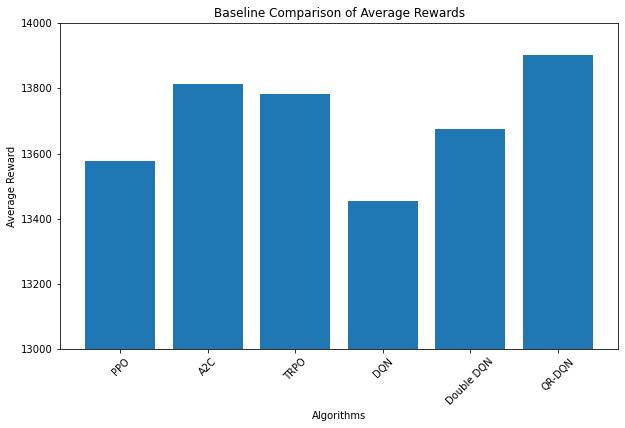

In [138]:
# Plot baseline comparison
import matplotlib.pyplot as plt

labels = ["PPO", "A2C", "TRPO", "DQN", "Double DQN", "QR-DQN"]
rewards = [ppo_avg_reward, a2c_avg_reward, trpo_avg_reward, dqn_avg_reward, ddqn_avg_reward, qrdqn_avg_reward]

plt.figure(figsize=(10, 6))
plt.bar(labels, rewards)
plt.title("Baseline Comparison of Average Rewards")
plt.ylabel("Average Reward")
plt.ylim(13000, 14000)
plt.xlabel("Algorithms")
plt.xticks(rotation=45)
plt.show()

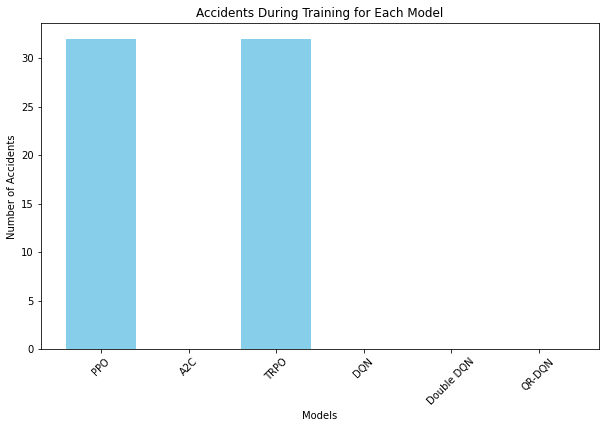

In [139]:
# Plot data for accidents during training for each model
models = ["PPO", "A2C", "TRPO", "DQN", "Double DQN", "QR-DQN"]
accidents = [32, 0, 32, 0, 0, 0]

plt.figure(figsize=(10, 6))
plt.bar(models, accidents, color="skyblue")
plt.title("Accidents During Training for Each Model")
plt.ylabel("Number of Accidents")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.show()

In [152]:
# Evaluation
def evaluate_agent(env, model, episodes=10):
    rewards = []
    states = []
    for _ in range(episodes):
        obs = env.reset()
        total_reward = 0
        episode_states = []
        for _ in range(50):
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_states.append(obs)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
        states.extend(episode_states)
    return np.mean(rewards), np.array(states)

In [153]:
# Baseline Comparison
def compare_with_baselines(env, model):
    strategies = {
        "Fixed": lambda _: 1,  # Medium supervision
        "Random": lambda _: np.random.choice([0, 1, 2]),
        "PPO": lambda obs: PPO_model.predict(obs)[0],
        "A2C": lambda obs: A2C_model.predict(obs)[0],
        "TRPO": lambda obs: TRPO_model.predict(obs)[0],
        "DQN": lambda obs: DQN_model.predict(obs)[0],
        "DDQN": lambda obs: DoubleDQN_model.predict(obs)[0],
        "QR-DQN": lambda obs: QRDQN_model.predict(obs)[0]
    }

    results = {}
    for strategy, policy in strategies.items():
        total_rewards = []
        for _ in range(10):
            obs = env.reset()
            total_reward = 0
            for _ in range(50):
                action = policy(obs)
                obs, reward, done, _ = env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)
        results[strategy] = np.mean(total_rewards)
    return results

In [154]:
# Scenario Testing
def run_scenario_testing(env, model, scenario_params, episodes=10):
    results = {
        "Fixed": [],
        "Random": [],
        "PPO": [],
        "A2C": [],
        "TRPO": [],
        "DQN": [],
        "DDQN": [],
        "QR-DQN": []
    }
    for params in scenario_params:
        env.environment.update(params)
        for strategy, policy in {
            "Fixed": lambda _: 1,
            "Random": lambda _: np.random.choice([0, 1, 2]),
            "PPO": lambda obs: PPO_model.predict(obs)[0],
            "A2C": lambda obs: A2C_model.predict(obs)[0],
            "TRPO": lambda obs: TRPO_model.predict(obs)[0],
            "DQN": lambda obs: DQN_model.predict(obs)[0],
            "DDQN": lambda obs: DoubleDQN_model.predict(obs)[0],
            "QR-DQN": lambda obs: QRDQN_model.predict(obs)[0]
        }.items():
            rewards = []
            for _ in range(episodes):
                obs = env.reset()
                total_reward = 0
                for _ in range(50):
                    action = policy(obs)
                    obs, reward, done, _ = env.step(action)
                    total_reward += reward
                    if done:
                        break
                rewards.append(total_reward)
            results[strategy].append(rewards)
    return results

In [155]:
# Compare results
baseline_results = compare_with_baselines(env, model)
print("\nBaseline Comparison Results:")
for strategy, reward in baseline_results.items():
    print(f"{strategy}: {reward:.2f}")


Baseline Comparison Results:
Fixed: 9797.40
Random: 9817.00
PPO: 13460.91
A2C: 13695.26
TRPO: 13753.24
DQN: 13717.95
DDQN: 13591.02
QR-DQN: 13755.48



Final Average Reward of PPO: 13606.23


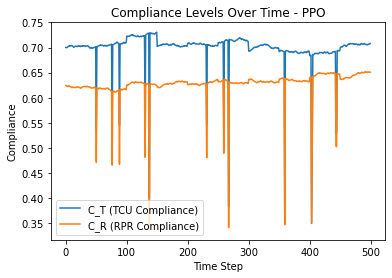

In [156]:
# Evaluate RL agent and plot performance
avg_reward, states = evaluate_agent(env, PPO_model)
print(f"\nFinal Average Reward of PPO: {avg_reward:.2f}")

plt.figure()
plt.plot(states[:, 1], label="C_T (TCU Compliance)")
plt.plot(states[:, 2], label="C_R (RPR Compliance)")
plt.title("Compliance Levels Over Time - PPO")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()


Final Average Reward of A2C: 13722.41


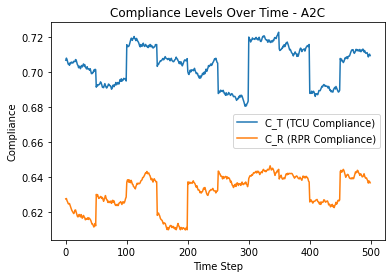

In [157]:
# Evaluate RL agent and plot performance
avg_reward, states = evaluate_agent(env, A2C_model)
print(f"\nFinal Average Reward of A2C: {avg_reward:.2f}")

plt.figure()
plt.plot(states[:, 1], label="C_T (TCU Compliance)")
plt.plot(states[:, 2], label="C_R (RPR Compliance)")
plt.title("Compliance Levels Over Time - A2C")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()


Final Average Reward of TRPO: 13685.28


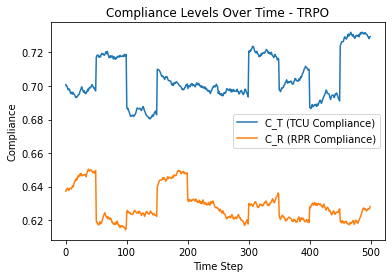

In [158]:
# Evaluate RL agent and plot performance
avg_reward, states = evaluate_agent(env, TRPO_model)
print(f"\nFinal Average Reward of TRPO: {avg_reward:.2f}")

plt.figure()
plt.plot(states[:, 1], label="C_T (TCU Compliance)")
plt.plot(states[:, 2], label="C_R (RPR Compliance)")
plt.title("Compliance Levels Over Time - TRPO")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()


Final Average Reward of DQN: 13548.71


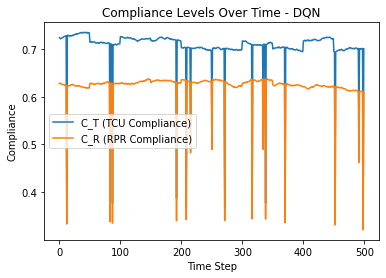

In [159]:
# Evaluate RL agent and plot performance
avg_reward, states = evaluate_agent(env, DQN_model)
print(f"\nFinal Average Reward of DQN: {avg_reward:.2f}")

plt.figure()
plt.plot(states[:, 1], label="C_T (TCU Compliance)")
plt.plot(states[:, 2], label="C_R (RPR Compliance)")
plt.title("Compliance Levels Over Time - DQN")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()


Final Average Reward of Double DQN: 13505.22


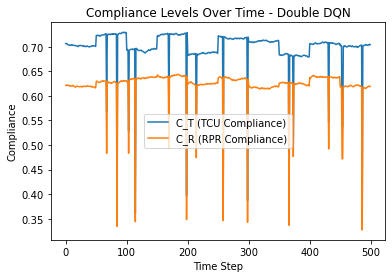

In [160]:
# Evaluate RL agent and plot performance
avg_reward, states = evaluate_agent(env, DoubleDQN_model)
print(f"\nFinal Average Reward of Double DQN: {avg_reward:.2f}")

plt.figure()
plt.plot(states[:, 1], label="C_T (TCU Compliance)")
plt.plot(states[:, 2], label="C_R (RPR Compliance)")
plt.title("Compliance Levels Over Time - Double DQN")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()


Final Average Reward of QR-DQN: 13633.35


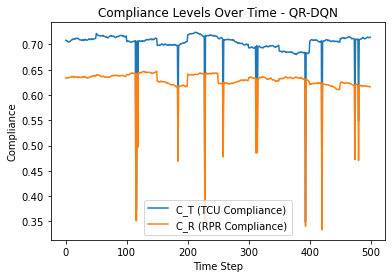

In [161]:
# Evaluate RL agent and plot performance
avg_reward, states = evaluate_agent(env, QRDQN_model)
print(f"\nFinal Average Reward of QR-DQN: {avg_reward:.2f}")

plt.figure()
plt.plot(states[:, 1], label="C_T (TCU Compliance)")
plt.plot(states[:, 2], label="C_R (RPR Compliance)")
plt.title("Compliance Levels Over Time - QR-DQN")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()

In [162]:
# Visualization for Fixed and Random Supervision Compliance
def compliance_over_time(env, strategy_name, policy, episodes=10):
    all_states = []
    for _ in range(episodes):
        obs = env.reset()
        episode_states = []
        for _ in range(50):
            action = policy(obs)
            obs, _, done, _ = env.step(action)
            episode_states.append(obs)
            if done:
                break
        all_states.extend(episode_states)
    return np.array(all_states)

In [163]:
# Collect compliance data
fixed_states = compliance_over_time(env, "Fixed Supervision", lambda _: 1)
random_states = compliance_over_time(env, "Random Supervision", lambda _: np.random.choice([0, 1, 2]))

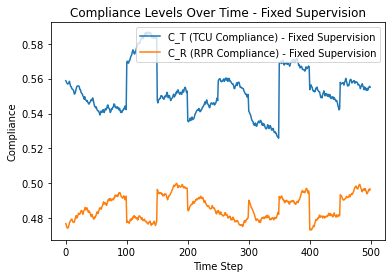

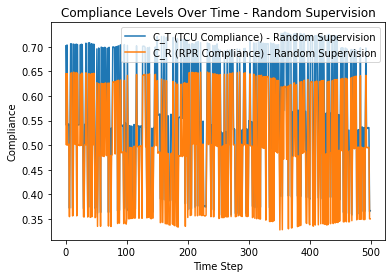

In [164]:
# Plot compliance comparison
plt.figure()
plt.plot(fixed_states[:, 1], label="C_T (TCU Compliance) - Fixed Supervision")
plt.plot(fixed_states[:, 2], label="C_R (RPR Compliance) - Fixed Supervision")
plt.title("Compliance Levels Over Time - Fixed Supervision")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()

plt.figure()
plt.plot(random_states[:, 1], label="C_T (TCU Compliance) - Random Supervision")
plt.plot(random_states[:, 2], label="C_R (RPR Compliance) - Random Supervision")
plt.title("Compliance Levels Over Time - Random Supervision")
plt.xlabel("Time Step")
plt.ylabel("Compliance")
plt.legend()
plt.show()

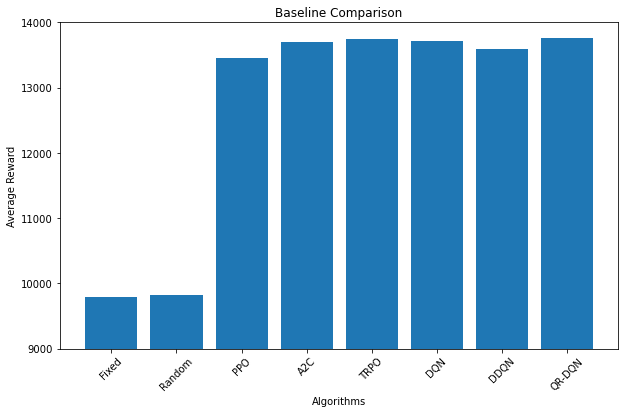

In [168]:
# Plot Baseline Comparison
plt.figure(figsize=(10, 6))
plt.bar(baseline_results.keys(), baseline_results.values())
plt.title("Baseline Comparison")
plt.ylabel("Average Reward")
plt.ylim(9000, 14000)
plt.xlabel("Supervision Strategies")
plt.xticks(rotation=45)
plt.show()

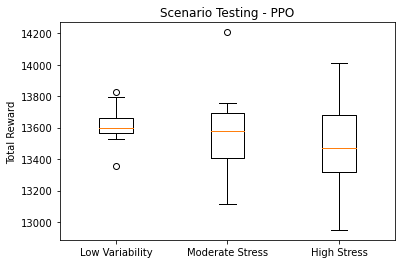

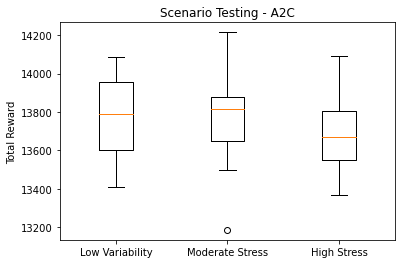

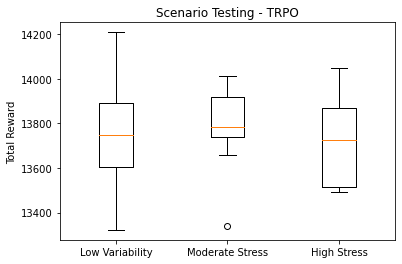

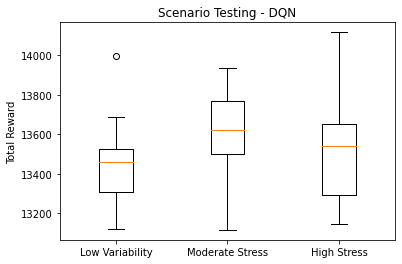

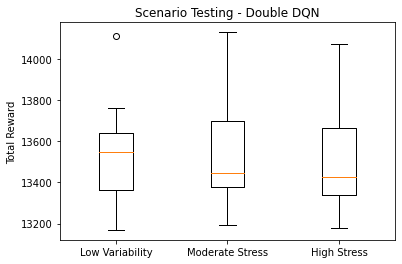

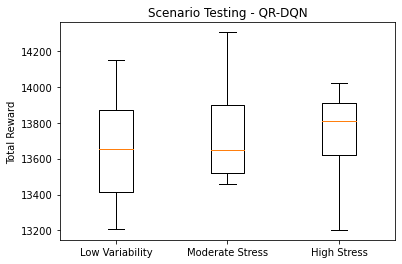

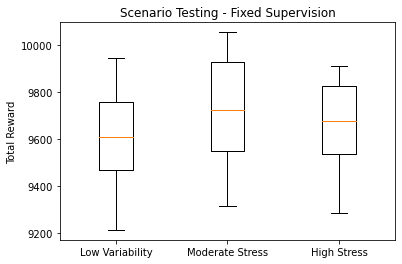

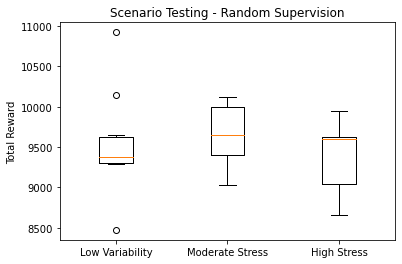

In [169]:
# Scenario Testing Visualization
scenario_params = [
    {"wind_speed": 0.3, "visibility": 0.7, "load_variability": 0.2},  # Scenario 1
    {"wind_speed": 0.5, "visibility": 0.4, "load_variability": 0.6},  # Scenario 2
    {"wind_speed": 0.7, "visibility": 0.2, "load_variability": 0.8}   # Scenario 3
]
scenario_names = ["Low Variability", "Moderate Stress", "High Stress"]
scenario_results = run_scenario_testing(env, model, scenario_params)

plt.figure()
plt.boxplot(scenario_results["PPO"], labels=scenario_names)
plt.title("Scenario Testing - PPO")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["A2C"], labels=scenario_names)
plt.title("Scenario Testing - A2C")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["TRPO"], labels=scenario_names)
plt.title("Scenario Testing - TRPO")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["DQN"], labels=scenario_names)
plt.title("Scenario Testing - DQN")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["DDQN"], labels=scenario_names)
plt.title("Scenario Testing - Double DQN")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["QR-DQN"], labels=scenario_names)
plt.title("Scenario Testing - QR-DQN")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["Fixed"], labels=scenario_names)
plt.title("Scenario Testing - Fixed Supervision")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.boxplot(scenario_results["Random"], labels=scenario_names)
plt.title("Scenario Testing - Random Supervision")
plt.ylabel("Total Reward")
plt.show()

In [170]:
fixed_results = scenario_results["Fixed"]
random_results = scenario_results["Random"]
ppo_results = scenario_results["PPO"]
a2c_results = scenario_results["A2C"]
trpo_results = scenario_results["TRPO"]
dqn_results = scenario_results["DQN"]
ddqn_results = scenario_results["DDQN"]
qrdqn_results = scenario_results["QR-DQN"]

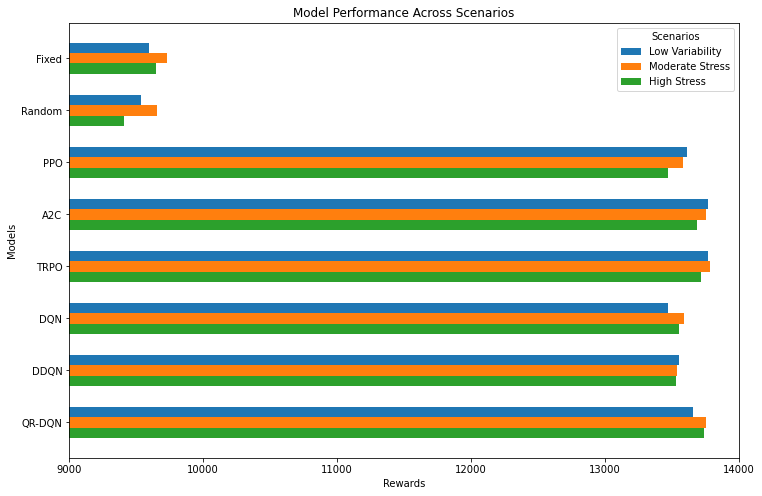

In [174]:
# Data for rewards in each scenario for each model (replace with actual data from `scenario_results`)
models = ["Fixed", "Random", "PPO", "A2C", "TRPO", "DQN", "DDQN", "QR-DQN"]
scenario_names = ["Low Variability", "Moderate Stress", "High Stress"]
scenario_rewards = {
    "Fixed": [np.mean(fixed_results[0]), np.mean(fixed_results[1]), np.mean(fixed_results[2])],
    "Random": [np.mean(random_results[0]), np.mean(random_results[1]), np.mean(random_results[2])],
    "PPO": [np.mean(ppo_results[0]), np.mean(ppo_results[1]), np.mean(ppo_results[2])],
    "A2C": [np.mean(a2c_results[0]), np.mean(a2c_results[1]), np.mean(a2c_results[2])],
    "TRPO": [np.mean(trpo_results[0]), np.mean(trpo_results[1]), np.mean(trpo_results[2])],
    "DQN": [np.mean(dqn_results[0]), np.mean(dqn_results[1]), np.mean(dqn_results[2])],
    "DDQN": [np.mean(ddqn_results[0]), np.mean(ddqn_results[1]), np.mean(ddqn_results[2])],
    "QR-DQN": [np.mean(qrdqn_results[0]), np.mean(qrdqn_results[1]), np.mean(qrdqn_results[2])],
}

# Prepare data for horizontal bar chart visualization
bar_width = 0.2
x = np.arange(len(models))  # X positions for the groups

# Create subplots for each scenario
plt.figure(figsize=(12, 8))

for i, scenario in enumerate(scenario_names):
    rewards = [scenario_rewards[model][i] for model in models]
    plt.barh(x + i * bar_width, rewards, bar_width, label=scenario)

# Set labels, titles, and legends
plt.yticks(x + bar_width, models)
plt.title("Model Performance Across Scenarios")
plt.xlabel("Rewards")
plt.xlim(9000, 14000)
plt.ylabel("Models")
plt.legend(scenario_names, title="Scenarios")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [179]:
print(scenario_rewards)

{'Fixed': [9592.940418749748, 9727.014119739475, 9649.043335407081], 'Random': [9537.790194538367, 9651.333415658815, 9408.42371996045], 'PPO': [13615.019078771153, 13584.007369619037, 13470.326429200848], 'A2C': [13769.07007141352, 13756.629528546133, 13688.070148884319], 'TRPO': [13765.421303498606, 13786.027748698189, 13720.269624441149], 'DQN': [13469.138748285939, 13593.10884308329, 13555.187656166509], 'DDQN': [13555.657308119427, 13535.080228783025, 13528.840538840659], 'QR-DQN': [13654.382455206423, 13754.320679265282, 13736.181514059961]}
